In [1]:
import pandas as pd
from scipy import interpolate
import rasterio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
import subprocess


## Functions used in this notebook

In [2]:
def interpolate_y(df, x_column, y_column, x_value):
    # Sort the DataFrame by the 'x' column to ensure interpolation works correctly
    df_sorted = df.sort_values(by=x_column)
    
    # Check if the x_value is within the range of the DataFrame
    if x_value < df_sorted[x_column].min() or x_value > df_sorted[x_column].max():
        return None  # x_value is out of range, cannot interpolate
    
    # Perform linear interpolation
    f = interpolate.interp1d(df_sorted[x_column], df_sorted[y_column], kind='linear')
    
    # Return the interpolated y value for the given x value
    return f(x_value)


# Function to perform raster calculation 
def raster_calculation(input_raster, output_raster, constant_value):
    with rasterio.open(input_raster) as src:
        # Read raster data
        raster_data = src.read(1)
        # Perform raster calculation
        result = raster_data - constant_value

        # Update metadata
        meta = src.meta
        meta.update(dtype=rasterio.float32)

        # Write the result to a new raster file
        with rasterio.open(output_raster, 'w', **meta) as dst:
            dst.write(result.astype(rasterio.float32), 1)
            
            

def raster_to_polygon(input_raster, output_polygon):
    # Run gdal_polygonize.py as a subprocess
    subprocess.call(["gdal_polygonize.py", input_raster, "-b", "1", "-f", "ESRI Shapefile", output_polygon, output_polygon, "COMID"])


## Download required HAND related data

These include the Height Above the Nearest Drainage (HAND) raster, the catchment raster, and the rating curve csv file.

In [ ]:
!wget https://web.corral.tacc.utexas.edu/nfiedata/HAND/160101/160101hand.tif

In [ ]:
!wget https://web.corral.tacc.utexas.edu/nfiedata/HAND/160101/160101catchhuc.tif

In [ ]:
!wget https://web.corral.tacc.utexas.edu/nfiedata/HAND/160101/hydroprop-fulltable-160101.nohand0.csv

## Read the NWM streamflow data

This is already retrieved from the other jupyter notebook.

In [6]:
df = pd.read_csv('subset_2008_retrospective_streamflow_at_usgs_10039500.csv')

In [7]:
df

,time,elevation,feature_id,gage_id,latitude,longitude,order,streamflow
0,2008-01-01 00:00:00,1847.49,7898927,b' 10039500',42.208435,-111.05989,6,9.21
1,2008-01-01 01:00:00,1847.49,7898927,b' 10039500',42.208435,-111.05989,6,9.21
2,2008-01-01 02:00:00,1847.49,7898927,b' 10039500',42.208435,-111.05989,6,9.21
3,2008-01-01 03:00:00,1847.49,7898927,b' 10039500',42.208435,-111.05989,6,9.21
4,2008-01-01 04:00:00,1847.49,7898927,b' 10039500',42.208435,-111.05989,6,9.21
...,...,...,...,...,...,...,...,...
8779,2008-12-31 19:00:00,1847.49,7898927,b' 10039500',42.208435,-111.05989,6,10.34
8780,2008-12-31 20:00:00,1847.49,7898927,b' 10039500',42.208435,-111.05989,6,10.34
8781,2008-12-31 21:00:00,1847.49,7898927,b' 10039500',42.208435,-111.05989,6,10.34
8782,2008-12-31 22:00:00,1847.49,7898927,b' 10039500',42.208435,-111.05989,6,10.34


The feature_id is the ID of the stream reach and its associated catchment for which the HAND results were created. 

In [8]:
comid = list(set(df['feature_id']))[0]
comid

7898927

From WBD_16 and QGIS I found the associated HUC8 for this gage. This is 16010102 (Central Bear).

## Estimate the stage associated with the NWM streamflow

First, we read the hydraulic properties csv file and then select the columns that are required for the rating curve.

In [16]:
hydro_prop = pd.read_csv('./hydroprop-fulltable-160101.nohand0.csv')

In [17]:
hydro_prop_sel = hydro_prop[hydro_prop['CatchId']==list(set(df['feature_id']))[0]]

In [18]:
hydro_prop_sel

,CatchId,Stage,Number of Cells,SurfaceArea (m2),BedArea (m2),Volume (m3),SLOPE,LENGTHKM,AREASQKM,Roughness,TopWidth (m),WettedPerimeter (m),WetArea (m2),HydraulicRadius (m),Discharge (m3s-1)
80012,7898927,0.0000,0,0.000000e+00,0.000000e+00,0.000000e+00,0.00001,4.746,5.8509,0.05,0.000000,0.000000,0.000000,0.000000,0.000000
80013,7898927,0.3048,2262,1.778898e+05,1.779038e+05,3.373110e+04,0.00001,4.746,5.8509,0.05,37.482057,37.485008,7.107269,0.189603,0.148353
80014,7898927,0.6096,4578,3.600287e+05,3.600810e+05,1.209768e+05,0.00001,4.746,5.8509,0.05,75.859402,75.870417,25.490260,0.335971,0.779122
80015,7898927,0.9144,5655,4.447265e+05,4.448274e+05,2.439053e+05,0.00001,4.746,5.8509,0.05,93.705541,93.726802,51.391758,0.548314,2.177425
80016,7898927,1.2192,6816,5.360300e+05,5.361864e+05,3.931010e+05,0.00001,4.746,5.8509,0.05,112.943533,112.976478,82.827856,0.733142,4.259239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80090,7898927,23.7744,36514,2.871530e+06,2.872680e+06,5.745202e+07,0.00001,4.746,5.8509,0.05,605.042145,605.284374,12105.356348,19.999453,5640.959544
80091,7898927,24.0792,36570,2.875934e+06,2.877093e+06,5.832801e+07,0.00001,4.746,5.8509,0.05,605.970013,606.214264,12289.930583,20.273245,5779.118659
80092,7898927,24.3840,36619,2.879787e+06,2.880952e+06,5.920523e+07,0.00001,4.746,5.8509,0.05,606.781897,607.027456,12474.764522,20.550577,5919.409246
80093,7898927,24.6888,36675,2.884191e+06,2.885364e+06,6.008366e+07,0.00001,4.746,5.8509,0.05,607.709765,607.957111,12659.852236,20.823594,6060.322864


In [19]:
hydro_prop_sel = hydro_prop_sel[['Stage','Discharge (m3s-1)']]

In [20]:
hydro_prop_sel

,Stage,Discharge (m3s-1)
80012,0.0000,0.000000
80013,0.3048,0.148353
80014,0.6096,0.779122
80015,0.9144,2.177425
80016,1.2192,4.259239
...,...,...
80090,23.7744,5640.959544
80091,24.0792,5779.118659
80092,24.3840,5919.409246
80093,24.6888,6060.322864


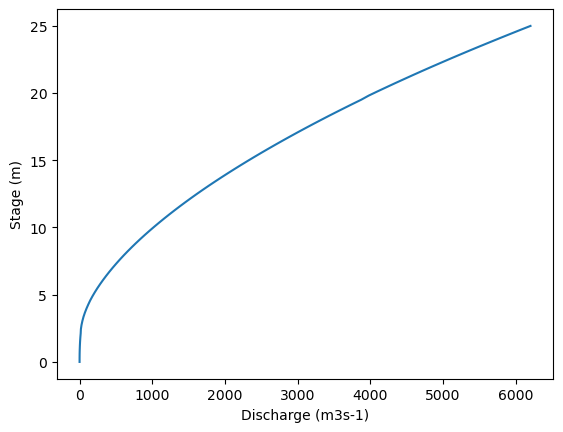

In [22]:
plt.plot(hydro_prop_sel['Discharge (m3s-1)'],hydro_prop_sel['Stage'])
plt.xlabel('Discharge (m3s-1)')
plt.ylabel('Stage (m)')
plt.show()

In [23]:
df.loc[df['streamflow'] == df['streamflow'].max()]

,time,elevation,feature_id,gage_id,latitude,longitude,order,streamflow
3551,2008-05-27 23:00:00,1847.49,7898927,b' 10039500',42.208435,-111.05989,6,109.669998


In [30]:
interpolate_stage = interpolate_y(hydro_prop_sel, 'Discharge (m3s-1)', 'Stage', 109.669998)
print('The estimated stage is: ', round(float(interpolate_stage), 2), ' m')

The estimated stage is:  4.15  m


## Compute the inundation extent

In [9]:
fim_v4 = pd.read_csv('./hydrotable.csv')

/tmp/ipykernel_424/3823441168.py:1: DtypeWarning: Columns (24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  fim_v4 = pd.read_csv('./hydrotable.csv')


In [10]:
fim_v4_sel = fim_v4[fim_v4['feature_id']==comid]

In [13]:
set(fim_v4_sel['HydroID'])

{27670036, 27670037, 27670038, 27670039, 27670042, 27670043, 27670044}

In [18]:
set(fim_v4_sel['branch_id'])

{0, 7897000001}

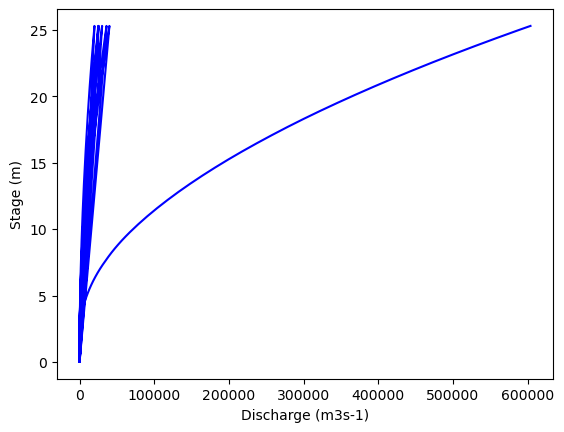

In [17]:
# plt.plot(hydro_prop_sel['Discharge (m3s-1)'],hydro_prop_sel['Stage'], color='gray')
fim_v4_sel_id = fim_v4_sel[fim_v4_sel['HydroID']==27670037]

# plt.plot(fim_v4_sel_id['discharge_cms'],fim_v4_sel_id['stage'], color='b')
plt.plot(fim_v4_sel['discharge_cms'],fim_v4_sel['stage'], color='b')
plt.xlabel('Discharge (m3s-1)')
plt.ylabel('Stage (m)')
plt.show()

In [56]:
fim_v4_sel.columns

Index(['HydroID', 'branch_id', 'feature_id', 'NextDownID', 'order_',
       'Number of Cells', 'SurfaceArea (m2)', 'BedArea (m2)', 'TopWidth (m)',
       'LENGTHKM', 'AREASQKM', 'WettedPerimeter (m)', 'HydraulicRadius (m)',
       'WetArea (m2)', 'Volume (m3)', 'SLOPE', 'ManningN', 'stage',
       'default_discharge_cms', 'default_Volume (m3)', 'default_WetArea (m2)',
       'default_HydraulicRadius (m)', 'default_ManningN', 'calb_applied',
       'last_updated', 'submitter', 'obs_source', 'precalb_discharge_cms',
       'calb_coef_usgs', 'calb_coef_spatial', 'calb_coef_final', 'HUC',
       'LakeID', 'subdiv_applied', 'channel_n', 'overbank_n',
       'subdiv_discharge_cms', 'discharge_cms', 'Bathymetry_source_x',
       'Bathymetry_source_y'],
      dtype='object')

## based on NFIE

May not be the ideal solution. It takes time to cliping the hand raster for a shapefile of interest. The recent version might have it for each cathcment.

In [36]:
input_raster = '160101catchhuc.tif'
output_polygon = '160101catchhuc.shp'

raster_to_polygon(input_raster, output_polygon)

0...10...20...30...40...50...60...70...80...90...100 - done.


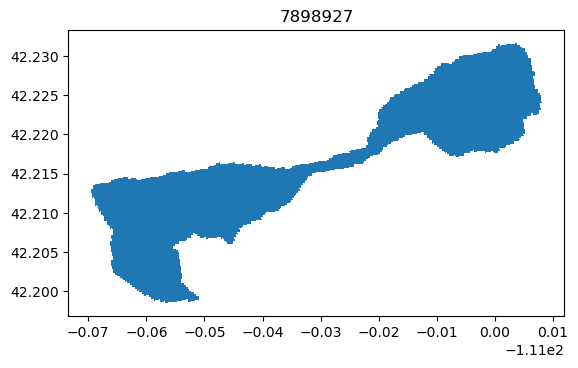

In [48]:
import geopandas as gpd
catch = gpd.read_file('./160101catchhuc.shp')
catch_sel = catch[catch['COMID']==comid]
catch_sel.plot()
plt.title(comid)
plt.show()

In [43]:
catch_sel.total_bounds

array([-111.0695177 ,   42.19850255, -110.99192121,   42.2316506 ])

In [42]:
!gdalwarp -overwrite -of GTiff -cutline 160101catchhuc.shp -cl 160101catchhuc -crop_to_cutline 160101hand.tif clipped_160101hand.tif


ERROR 1: Failed to identify source layer from datasource.


In [46]:
!gdalwarp -overwrite -wo NUM_THREADS=4 -co TILED=YES -co COMPRESS=PACKBITS -co BIGTIFF=YES -cutline 160101catchhuc.shp -crop_to_cutline 160101hand.tif clipped_160101hand.tif


Creating output file that is 9854P x 20465L.
Processing 160101hand.tif [1/1] : 0Using internal nodata values (e.g. -3.40282e+38) for image 160101hand.tif.
Copying nodata values from source 160101hand.tif to destination clipped_160101hand.tif.
^C


In [32]:
# Read the input raster file
input_raster = '160101hand.tif'
# Define the output raster file
output_raster = 'inundation_for_max_flow.tif'
# Define the constant value to be added
constant_value = round(float(interpolate_stage), 2)

# Perform raster calculation
raster_calculation(input_raster, output_raster, constant_value)


In [20]:
with rasterio.open(output_raster) as src:
    # Read raster data
    raster_data = src.read(1)

In [ ]:
# import numpy as np

# def update_raster_values(raster_data):
#     # Create a mask for values greater than or equal to 0
#     mask = raster_data >= 0
    
#     # Apply the condition to update the values
#     updated_raster_data = np.where(mask, 1, 0)
    
#     # Preserve NaN values
#     updated_raster_data[np.isnan(raster_data)] = np.nan
    
#     return updated_raster_data



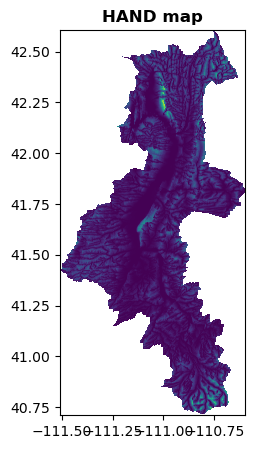

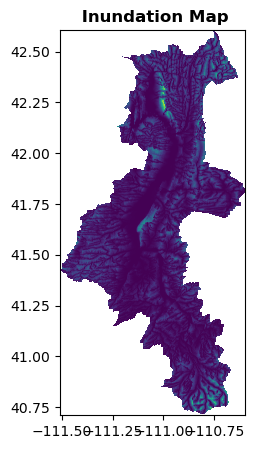

In [19]:
# Plot the original raster
with rasterio.open(input_raster) as src:
    plt.figure(figsize=(10, 5))
    show(src, title= "HAND map")

# Plot the resulting raster after raster calculation
with rasterio.open(output_raster) as src:
    plt.figure(figsize=(10, 5))
    show(src, title=" Inundation Map")

plt.show()